### The Battle of the Neighborhoods

#### Data

The city I have chosen to analyse is: __London__

__Data 1__

The first set of data will be from looking at the make-up of London itself as well as defining the boundaries of London. There is the 'City of London' which is known as 'the square mile' making up only 1.12miles squared - it even has it's own police service seperate to the Metropolitan Police who police the rest of London and it's 32 Boroughs. 

For this data, it will be 'The Greater London Area' that we are referring to. So everything up to Enfield, down to Croydon and over to Hillingdon in the West and Havering in the East.

This data will be extracted from Wikipedia and will also use FourSquare.

London's 32 boroughs;
https://en.wikipedia.org/wiki/List_of_areas_of_London 

This will be scraped below;


In [2]:
#import relevant libraries required.

from bs4 import BeautifulSoup
import numpy as np

#import pandas and set limiters on columns/rows.
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
print('libraries numpy, pandas, json imported')

#install our geopy handling library
!pip install -q install geopy
print('geopy installed')

from geopy.geocoders import Nominatim
print('Nominatim imported')

libraries numpy, pandas, json imported
geopy installed
Nominatim imported


In [4]:
#other libraries to install
import requests

#system to convert JSON files into pandas dataframes
from pandas.io.json import json_normalize

print('import successful')

import successful


In [5]:
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplot imported')

#clustering tools
from sklearn.cluster import KMeans

!pip -q install geocoder
import geocoder
import time

print('You have time!')

matplot imported
You have time!


In [6]:
!conda install -c conda-forge folium=0.5.0 --yes
!pip -q install folium 

print('folium installed')
import folium
print('folium finished')

Solving environment: ...working... done

# All requested packages already installed.

folium installed
folium finished


In [7]:
#Now we can begin looking at the data
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [10]:
#Cleaning the web page to extract just the table data we are after
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')

table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [11]:
#Extract data

rows = table.find_all('tr')

In [12]:
columns = [i.text.replace('\n', '')
          for i in rows[0].find_all('th')]

In [13]:
#convert to a pandas df

df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [14]:
#Now we will extract the rows of data and incorporate it into our table

for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [15]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [16]:
#rename some of the columns to better fit our needs

df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-Town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [17]:
df.head(5)

,Location,Borough,Post-Town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [18]:
#We will now remove the [x] next to the boroughs

df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [19]:
#see shape of table
df.shape

(533, 6)

In [20]:
df.head(5)

,Location,Borough,Post-Town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


__Post codes__
Due to the size of some boroughs, they will contain multiple postcodes. To combat this, I will split the multi-lines into singular.

In [22]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [23]:
df0.head(5)

,Location,Borough,Post-Town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [25]:
#Only data from certain headers will be used, we will now drop the columns not needed.

df1 = df0[['Location', 'Borough', 'Postcode', 'Post-Town']].reset_index(drop=True)

In [26]:
df1.head(5)

,Location,Borough,Postcode,Post-Town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [29]:
#Now remove all non-London post-towns
df2 = df1
df21 = df2[df2['Post-Town'].str.contains('LONDON')]

In [30]:
df21.head(5)

,Location,Borough,Postcode,Post-Town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [31]:
#We will now also drop the 'Post-town' column as we now know we only have the towns within London.

df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [34]:
df3.head(20)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [35]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

__Specific area to review__

The area of London I wish to focus is the diverse area of the South and South East. Contained within here we have London's famous 'Borough Market' just by London Bridge. A great place to get any kind of food you can imagine.

In [36]:
df_london.Postcode = df_london.Postcode.str.strip()

In [37]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [38]:
#Now we will extract all postcodes only within South East London (SE postcodes)

df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [39]:
#So now we should only see SE postcode areas below

df_se.head(20)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


__Data 2__

We will now examine the demographics of these areas to work out the proportion of nationalities. This area of London is very diverse with a large make-up of Afro-Caribbran populace.
This data will enable us to gain a better idea of what cuisine is likely to be found. For this, we are using demographic data from Wikipedia.

https://en.wikipedia.org/wiki/Demography_of_London


__Data 3__

We will next be looking at obtaining the location data for our targetted areas. To accomplish this, we will be using a Geocoder which will provide longitude and latitudes.

We will create this data frame for our SE locations below;

In [55]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [57]:
#This will return the co-ordinates for the SE2 postcode
sample = get_latlng('SE2')
sample

[51.492450000000076, 0.12127000000003818]

In [59]:
#We now apply this to our entire data frame of SE post-codes

start = time.time()

postal_codes = df_se['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  50.5660560131073 seconds


In [61]:
#Now we add the co-ordinates to our table
df_se_loc = df_se

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [62]:
df_se_loc.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.49245,0.12127
1,Crofton Park,Lewisham,SE4,51.46268,-0.03558
2,Crossness,Bexley,SE2,51.49245,0.12127
3,Crystal Palace,Bromley,SE19,51.41990,-0.08808
4,Crystal Palace,Bromley,SE20,51.41009,-0.05683


__Data 3__

Finally, we will be using FourSquare geographical location data to explore the boroughs/postal codes with greater ease.

## Methodology

We will now look at our data after pre-processing scraped data from wikipedia to access which area would be the best to establish a new restaurant with the South-East of London.

In [66]:
# Resets the current index to a new
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [67]:
se_df.shape

(80, 5)

In [68]:
se_df

,Location,Borough,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.49245,0.12127
1,Crofton Park,Lewisham,SE4,51.46268,-0.03558
2,Crossness,Bexley,SE2,51.49245,0.12127
3,Crystal Palace,Bromley,SE19,51.41990,-0.08808
4,Crystal Palace,Bromley,SE20,51.41009,-0.05683
5,Crystal Palace,Bromley,SE26,51.42674,-0.05533
6,Denmark Hill,Southwark,SE5,51.47480,-0.09313
7,Deptford,Lewisham,SE8,51.48114,-0.02467
8,Dulwich,Southwark,SE21,51.44100,-0.08897
9,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [69]:
#Personally, I work in Lambeth so I would like to see some further information about the surrounding area.

se_df.loc[se_df['Location'] == 'Lambeth']

,Location,Borough,Postcode,Latitude,Longitude
29,Lambeth,Lambeth,SE1,51.49996,-0.09568


In [70]:
se_df.loc[29, 'Location']

'Lambeth'

In [71]:
lambeth_lat = se_df.loc[29, 'Latitude']
lambeth_long = se_df.loc[29, 'Longitude']
lambeth_loc = se_df.loc[29, 'Location']
lambeth_postcode = se_df.loc[29, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lambeth_loc,
                                                                                         lambeth_postcode,
                                                                                         lambeth_lat,
                                                                                         lambeth_long))

The latitude and longitude values of Lambeth with postcode SE1, are 51.499960000000044, -0.09567999999995891.


Now let's explore some venues within the area of Lambeth.

In [73]:
#Foursquare credentials

CLIENT_ID = '0OUTBLOYMNG1T1CRVPEMAFWOHT10YH4CFG1REEWWU5NUESYO' # your Foursquare ID
CLIENT_SECRET = 'U0OSYDLUVGPBDOP2KYKUXKXJMPVPGWEMIRSUO12DQCYN0BIF' # your Foursquare Secret
VERSION = '20200822'

In [75]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lambeth_lat, 
    lambeth_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0OUTBLOYMNG1T1CRVPEMAFWOHT10YH4CFG1REEWWU5NUESYO&client_secret=U0OSYDLUVGPBDOP2KYKUXKXJMPVPGWEMIRSUO12DQCYN0BIF&v=20200822&ll=51.499960000000044,-0.09567999999995891&radius=2000&limit=100'

In [76]:
#We will then send a request to get the results from this request

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f4105214f3e540acf2f444b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Southwark',
  'headerFullLocation': 'Southwark, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 51.51796001800006,
    'lng': -0.06681900126877119},
   'sw': {'lat': 51.48195998200003, 'lng': -0.12454099873114663}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '577e6189498e861ea3422691',
       'name': 'Mercato Metropolitano',
       'location': {'address': '42 Newington Causeway',
        'lat': 51.498318,
        'lng': -0.098162144,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.

In [77]:
#Now let's tidy this up.

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [79]:
from pandas import json_normalize

In [80]:
#and transform it into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [81]:
nearby_venues

,name,categories,lat,lng
0,Mercato Metropolitano,Street Food Gathering,51.498318,-0.098162
1,Terry's Cafe,Café,51.500715,-0.098314
2,Southwark Playhouse,Theater,51.497779,-0.098603
3,German Kraft,Brewery,51.498662,-0.098935
4,The Gladstone Arms,Pub,51.500961,-0.095031
5,Cobbler's Nest,Shoe Store,51.502275,-0.094890
6,Casa do Frango,Portuguese Restaurant,51.504752,-0.092908
7,M&S Simply Food,Grocery Store,51.505517,-0.098047
8,The Gentlemen Baristas,Coffee Shop,51.503849,-0.094635
9,Honest Burgers,Burger Joint,51.504622,-0.091064


In [82]:
nearby_venues_lambeth_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [83]:
nearby_venues_lambeth_unique.head(5)

,Count
Pub,8
Coffee Shop,8
Hotel,5
Theater,4
Street Food Gathering,4


From this, we can see that the majority of venue types within Lambeth are pubs and coffee shops. Restaurants are not even in the top 5. Let's see if they are in the top 10..

In [84]:
nearby_venues_lambeth_unique.head(10)

,Count
Pub,8
Coffee Shop,8
Hotel,5
Theater,4
Street Food Gathering,4
Italian Restaurant,4
Burger Joint,3
Scenic Lookout,3
Restaurant,3
Tapas Restaurant,3


Way down at the bottom here, we see that there are some restaurants in Lambeth! I know this to be true as Lambeth is a commuter heavy area of South East London. There are more Pret-A-Mangers in a small area that most other parts - this is reflected by the coffee shop being in tied first spot with pubs.

People go to the coffee shops on their way into work and head home via the pub.

A slight caveat here - we only examined 100 locations within Lambeth. Expanding the search may provide slightly different results but this will be fairly comparible throughout all of the data.


__Multiple Boroughs__

Let's examine a few boroughs at once.

In [85]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [86]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Abbey Wood
Crofton Park
Crossness
Crystal Palace
Crystal Palace
Crystal Palace
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Eltham
Falconwood
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Greenwich
Grove Park
Herne Hill
Hither Green
Honor Oak
Horn Park
Kennington
Kidbrooke
Ladywell
Ladywell
Lambeth
Lee
Lewisham
Beckenham
Longlands
Maze Hill
Middle Park
Mottingham
New Cross
New Eltham
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Penge
Plumstead
Rotherhithe
Selhurst
Shooter's Hill
Bermondsey
South Norwood
Southend
St Johns
Bexleyheath (also Bexley New Town)
Surrey Quays
Sydenham (also Lower Sydenham, Upper Sydenham)
Sydenham Hill
Sydenham Hill
Thamesmead
Thamesmead
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Well Hall
Blackheath
West Heath
Blackheath Royal Standard
Blackheath Royal Standard
West Norwood
Westcombe Park
Woolwich
Brixton
Brockley
Camberwell
Catford
Charlton
Anerley
Chinbrook


In [87]:
se_venues.shape

(6671, 7)

In [88]:
len(se_venues)

6671

In [89]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [90]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.49245,0.12127,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,51.49245,0.12127,Lidl,51.496152,0.118417,Supermarket
2,Abbey Wood,51.49245,0.12127,Sainsbury's,51.492826,0.120524,Supermarket
3,Abbey Wood,51.49245,0.12127,Morrisons,51.507276,0.105392,Supermarket
4,Abbey Wood,51.49245,0.12127,Co-op Food,51.487650,0.113490,Grocery Store


In [91]:
#We can then look at the number of venues per area.
se_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Abbey Wood,16,16,16,16,16,16
Anerley,100,100,100,100,100,100
Bankside,100,100,100,100,100,100
Beckenham,100,100,100,100,100,100
Bellingham,67,67,67,67,67,67
Bermondsey,100,100,100,100,100,100
Bexleyheath (also Bexley New Town),16,16,16,16,16,16
Blackheath,91,91,91,91,91,91
Blackheath Royal Standard,146,146,146,146,146,146


In [92]:
#Check for unique venues

print('There are {} uniques categories.'.format(len(se_venues['Venue Category'].unique())))

There are 213 uniques categories.


We can now break these down to see what the most common type of venue is

In [93]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')

In [94]:
se_venue_unique_count.head(5)

,Count
Pub,720
Coffee Shop,429
Café,366
Park,349
Grocery Store,302


As we can see above, this is comparible with the single borough of Lambeth we looked at before. Both Pub and coffee shop are in the top 2 but pub has almost double the amount of venue locations as the coffee shops.

With that being said, if we were to classify the cafes as a coffee shop - since they are relatively similar, this number would be about equal. 

## Clustering and Visualisation

#### Packages

Before beginning, we must ensure the correct libraries are installed. This has been done at the beginning of this notebook.

In [95]:
# To begin, we must obtain the co-ordinates for London

address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [96]:
#Folium is then used obtain co-ordinates
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

We will then show the SE boroughs over the top of this map to highlight the areas we are looking at.

In [97]:
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [98]:
type(se_df)

pandas.core.frame.DataFrame

### Inidividual location analytics

We will now use techniques such as hot encoding and re-arrangement to explore individual neighbourhoods/boroughs.

In [99]:
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [100]:
# add neighborhood column back to dataframe
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [101]:
# move neighborhood column to the first column
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [102]:
se_onehot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Cable Car,Café,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Paintball Field,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sake Bar,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0

This now shows the breakdown of types of venue based on their location.
I'm quite partial to a whisky and I can see that 'Whisky Bar' is amongst the categories. Let's see which location I'd be best to go to for this type of venue.

In [103]:
se_onehot.loc[se_onehot['Whisky Bar'] != 0]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Cable Car,Café,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Paintball Field,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sake Bar,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
84,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2397,Ladywell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3205,New Cross,0,0

Well.. they seem to be quite hard to come by!

Let's look at a different type of venue then. Since we're trying to decide which area to set up a new restaurant we should probably pick a cuisine type. Let's try Italian.

In [105]:
se_onehot.loc[se_onehot['Italian Restaurant'] != 0]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Cable Car,Café,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Paintball Field,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sake Bar,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
54,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,Crofton Park,

In [106]:
#Now let's use this method to anaylyse Lambeth again;


se_onehot.loc[se_onehot['Neighbourhood'] == 'Lambeth']

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Cable Car,Café,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Paintball Field,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sake Bar,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
2529,Lambeth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2530,Lambeth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2531,Lambeth,0,0,0,0,0

From the above table we can see that Lambeth is the top place in some areas for Italian, but is still quite lacking.

In [107]:
se_onehot.to_csv('selondon_onehot.csv', index = False)

In [108]:
#New dataframe size
se_onehot.shape

(6671, 214)

#### Regrouping and Category Statistics

In [109]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Cable Car,Café,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Paintball Field,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sake Bar,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Abbey Wood,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.062500,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0625,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.125000,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.062500,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125000,0.00,0.062500,0.0,0.0,0.000000,0.00,0.0625,0.00,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00,0.000000,0.062500,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.00,0.00,0.00,0.00,0.000000,0.0,0.00,

In [110]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (80, 5)
After One-hot encoding: (69, 214)


In [111]:
se_grouped.to_csv('london_grouped.csv', index = False)

In [112]:
# We will now group boroughs with 10 most common venue types

num_top_venues = 10

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Abbey Wood----
                         venue  freq
0                  Supermarket  0.19
1         Fast Food Restaurant  0.12
2                Grocery Store  0.12
3                Historic Site  0.06
4               Clothing Store  0.06
5         Gym / Fitness Center  0.06
6       Furniture / Home Store  0.06
7                     Pharmacy  0.06
8                Train Station  0.06
9  Eastern European Restaurant  0.06


----Anerley----
                  venue  freq
0                   Pub  0.11
1           Supermarket  0.07
2                  Café  0.07
3           Pizza Place  0.06
4           Coffee Shop  0.06
5         Grocery Store  0.04
6    Italian Restaurant  0.04
7             Gastropub  0.04
8                  Park  0.04
9  Gym / Fitness Center  0.04


----Bankside----
                   venue  freq
0            Coffee Shop  0.08
1                    Pub  0.08
2                  Hotel  0.05
3                Theater  0.04
4     Italian Restaurant  0.04
5  Street Food Gather

We will now re-organise the information above and put it into a pandas dataframe. Which will show the most common venues.

In [113]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [115]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Supermarket,Grocery Store,Fast Food Restaurant,Pub,Clothing Store,Furniture / Home Store,Pharmacy,Train Station,Gym / Fitness Center,Eastern European Restaurant
1,Anerley,Pub,Café,Supermarket,Coffee Shop,Pizza Place,Gym / Fitness Center,Grocery Store,Italian Restaurant,Park,Gastropub
2,Bankside,Pub,Coffee Shop,Hotel,Street Food Gathering,Theater,Italian Restaurant,Restaurant,Tapas Restaurant,Burger Joint,Art Museum
3,Beckenham,Pub,Café,Supermarket,Coffee Shop,Pizza Place,Gym / Fitness Center,Grocery Store,Italian Restaurant,Park,Gastropub
4,Bellingham,Grocery Store,Supermarket,Park,Café,Coffee Shop,Pub,Italian Restaurant,Fast Food Restaurant,Train Station,Hardware Store


In [116]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [117]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)

#### Clustering of Boroughs

Using K-means, we will now create clusters of the boroughs and seperate it into 5 clusters.

In [118]:
#Below is our number of clusters
kclusters = 5

kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 0, 4, 2, 0, 1, 2, 2, 0])

In [119]:
#Create a new df which includes the top 10 venues and the clusters we just created

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [120]:
se_merged = se_df

In [121]:
se_merged.head(3)

,Location,Borough,Postcode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.49245,0.12127
1,Crofton Park,Lewisham,SE4,51.46268,-0.03558
2,Crossness,Bexley,SE2,51.49245,0.12127


In [122]:
#Merging this data with lat/long for each borough
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [123]:
se_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,"Bexley, Greenwich",SE2,51.49245,0.12127,1,Supermarket,Grocery Store,Fast Food Restaurant,Pub,Clothing Store,Furniture / Home Store,Pharmacy,Train Station,Gym / Fitness Center,Eastern European Restaurant
1,Crofton Park,Lewisham,SE4,51.46268,-0.03558,0,Pub,Coffee Shop,Park,Café,Bar,Gastropub,Italian Restaurant,Pizza Place,Food Truck,Cocktail Bar
2,Crossness,Bexley,SE2,51.49245,0.12127,1,Supermarket,Grocery Store,Fast Food Restaurant,Pub,Clothing Store,Furniture / Home Store,Pharmacy,Train Station,Gym / Fitness Center,Eastern European Restaurant
3,Crystal Palace,Bromley,SE19,51.41990,-0.08808,4,Pub,Coffee Shop,Café,Supermarket,Italian Restaurant,Park,Pizza Place,Gastropub,Train Station,Gym / Fitness Center
4,Crystal Palace,Bromley,SE20,51.41009,-0.05683,4,Pub,Coffee Shop,Café,Supermarket,Italian Restaurant,Park,Pizza Place,Gastropub,Train Station,Gym / Fitness Center


In [124]:
se_clusters = se_merged_latlong

### Data Analysis of Clusters

Within this section we will analyse and visualise the data above and work out which venues are most popular within SE London and also which cuisine would be most popular where.

Using this data we can then advise the company on where to set-up shop.

In [125]:
#import required libraries
%matplotlib inline
import matplotlib
import numpy as np

print('Success!')

Success!


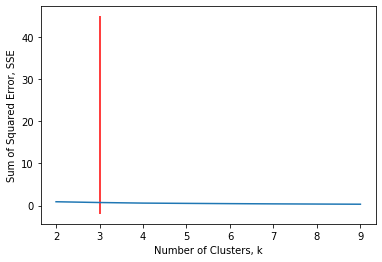

In [126]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

#### Silhouette coefficient

is a useful method of analysis to find the optimal value of the clusters. 

In [127]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.6902239335122877
Where n_clusters = 3, the Silhouette Coefficient is 0.6731520102865589
Where n_clusters = 4, the Silhouette Coefficient is 0.6663111887414048
Where n_clusters = 5, the Silhouette Coefficient is 0.695503672171252
Where n_clusters = 6, the Silhouette Coefficient is 0.7798187771292893
Where n_clusters = 7, the Silhouette Coefficient is 0.8037924304533735
Where n_clusters = 8, the Silhouette Coefficient is 0.870253134292505
Where n_clusters = 9, the Silhouette Coefficient is 0.9223740149354457


The higher the number, the better the coefficient. Remember we used a cluster value of 5.

In [128]:
se_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [129]:
#Now let's visualise these resulting clusters!

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

__Cluster 1__

In [130]:
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Lewisham,0,Pub,Coffee Shop,Park,Café,Bar,Gastropub,Italian Restaurant,Pizza Place,Food Truck,Cocktail Bar
6,Southwark,0,Café,Coffee Shop,Park,Cocktail Bar,Pub,Middle Eastern Restaurant,Pizza Place,Beer Bar,Bar,Brewery
10,Southwark,0,Pub,Coffee Shop,Café,Park,Theater,Italian Restaurant,Street Food Gathering,Hotel,Garden,Art Gallery
11,Southwark,0,Pub,Coffee Shop,Café,Park,Theater,Italian Restaurant,Street Food Gathering,Hotel,Garden,Art Gallery
12,Southwark,0,Pub,Coffee Shop,Café,Park,Theater,Italian Restaurant,Street Food Gathering,Hotel,Garden,Art Gallery
15,Southwark,0,Pub,Coffee Shop,Hotel,Street Food Gathering,Theater,Italian Restaurant,Restaurant,Tapas Restaurant,Burger Joint,Art Museum
21,Lambeth,0,Coffee Shop,Pub,Café,Pizza Place,Market,Park,Brewery,Vegetarian / Vegan Restaurant,Bakery,Restaurant
25,"Lambeth, Southwark",0,Café,Pub,Park,Coffee Shop,Hotel,Theater,Garden,Bar,Cricket Ground,Gastropub
29,Lambeth,0,Pub,Coffee Shop,Hotel,Street Food Gathering,Theater,Italian Restaurant,Restaurant,Tapas Restaurant,Burger Joint,Art Museum
39,Southwark,0,Coffee Shop,Pub,Café,Theater,Italian Restaurant,Park,Street Food Gathering,Hotel,Pizza Place,Tapas Restaurant


__Cluster 2__

In [131]:
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bexley, Greenwich",1,Supermarket,Grocery Store,Fast Food Restaurant,Pub,Clothing Store,Furniture / Home Store,Pharmacy,Train Station,Gym / Fitness Center,Eastern European Restaurant
2,Bexley,1,Supermarket,Grocery Store,Fast Food Restaurant,Pub,Clothing Store,Furniture / Home Store,Pharmacy,Train Station,Gym / Fitness Center,Eastern European Restaurant
54,Bexley,1,Supermarket,Grocery Store,Fast Food Restaurant,Pub,Clothing Store,Furniture / Home Store,Pharmacy,Train Station,Gym / Fitness Center,Eastern European Restaurant
59,"Bexley, Greenwich",1,Supermarket,Grocery Store,Fast Food Restaurant,Warehouse Store,Pharmacy,Train Station,Gym / Fitness Center,Convenience Store,Historic Site,Clothing Store
60,"Bexley, Greenwich",1,Supermarket,Grocery Store,Fast Food Restaurant,Warehouse Store,Pharmacy,Train Station,Gym / Fitness Center,Convenience Store,Historic Site,Clothing Store
67,Bexley,1,Supermarket,Grocery Store,Fast Food Restaurant,Pub,Clothing Store,Furniture / Home Store,Pharmacy,Train Station,Gym / Fitness Center,Eastern European Restaurant


__Cluster 3__

In [132]:
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Lewisham,2,Grocery Store,Pub,Park,Café,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Train Station,Gym / Fitness Center,Supermarket
24,"Greenwich, Lewisham",2,Grocery Store,Pub,Park,Café,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Train Station,Gym / Fitness Center,Supermarket
26,Greenwich,2,Pub,Coffee Shop,Grocery Store,Park,Gym / Fitness Center,Bakery,Supermarket,Garden,Italian Restaurant,Historic Site
30,Lewisham,2,Grocery Store,Pub,Park,Café,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Train Station,Gym / Fitness Center,Supermarket
43,Lewisham,2,Grocery Store,Supermarket,Park,Café,Coffee Shop,Pub,Italian Restaurant,Fast Food Restaurant,Train Station,Hardware Store
46,Greenwich,2,Grocery Store,Pub,Bakery,Hotel,Chinese Restaurant,Clothing Store,Coffee Shop,Park,Train Station,Supermarket
48,Croydon,2,Pub,Grocery Store,Coffee Shop,Park,Café,Train Station,Supermarket,Gym Pool,Caribbean Restaurant,Soccer Stadium
49,Greenwich,2,Grocery Store,Pub,Bakery,Hotel,Chinese Restaurant,Clothing Store,Coffee Shop,Park,Train Station,Supermarket
51,Croydon,2,Pub,Grocery Store,Coffee Shop,Park,Café,Train Station,Supermarket,Gym Pool,Caribbean Restaurant,Soccer Stadium
52,Lewisham,2,Grocery Store,Supermarket,Park,Café,Coffee Shop,Pub,Italian Restaurant,Fast Food Restaurant,Train Station,Hardware Store


__CLuster 4__

In [133]:
se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Greenwich,3,Grocery Store,Fast Food Restaurant,Park,Pub,Pizza Place,Mediterranean Restaurant,Department Store,Platform,Bar,Pharmacy
14,"Bexley, Greenwich",3,Grocery Store,Fast Food Restaurant,Park,Pub,Pizza Place,Mediterranean Restaurant,Department Store,Platform,Bar,Pharmacy
33,Bexley,3,Grocery Store,Fast Food Restaurant,Park,Pub,Pizza Place,Mediterranean Restaurant,Department Store,Platform,Bar,Pharmacy
35,Greenwich,3,Grocery Store,Fast Food Restaurant,Park,Pub,Pizza Place,Mediterranean Restaurant,Department Store,Platform,Bar,Pharmacy
36,Bromley,3,Grocery Store,Fast Food Restaurant,Park,Pub,Pizza Place,Mediterranean Restaurant,Department Store,Platform,Bar,Pharmacy
38,Greenwich,3,Grocery Store,Fast Food Restaurant,Park,Pub,Pizza Place,Mediterranean Restaurant,Department Store,Platform,Bar,Pharmacy
65,Greenwich,3,Grocery Store,Fast Food Restaurant,Park,Pub,Pizza Place,Mediterranean Restaurant,Department Store,Platform,Bar,Pharmacy


__Cluster 5__

In [134]:
se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bromley,4,Pub,Coffee Shop,Café,Supermarket,Italian Restaurant,Park,Pizza Place,Gastropub,Train Station,Gym / Fitness Center
4,Bromley,4,Pub,Coffee Shop,Café,Supermarket,Italian Restaurant,Park,Pizza Place,Gastropub,Train Station,Gym / Fitness Center
5,Bromley,4,Pub,Coffee Shop,Café,Supermarket,Italian Restaurant,Park,Pizza Place,Gastropub,Train Station,Gym / Fitness Center
7,Lewisham,4,Pub,Café,Coffee Shop,Park,Bar,Garden,Trail,Pizza Place,Deli / Bodega,Market
8,Southwark,4,Pub,Café,Park,Bakery,Coffee Shop,Grocery Store,Brewery,Gym / Fitness Center,Farmers Market,Italian Restaurant
9,Southwark,4,Pub,Café,Park,Pizza Place,Coffee Shop,Italian Restaurant,Cocktail Bar,Bakery,Mediterranean Restaurant,Platform
16,Lewisham,4,Pub,Coffee Shop,Grocery Store,Café,Supermarket,Park,Gym / Fitness Center,Gastropub,Bar,Pizza Place
17,Lambeth,4,Pub,Coffee Shop,Café,Grocery Store,Bakery,Park,Italian Restaurant,Supermarket,Train Station,Brewery
18,Lambeth,4,Pub,Coffee Shop,Café,Grocery Store,Bakery,Park,Italian Restaurant,Supermarket,Train Station,Brewery
19,Greenwich,4,Pub,Park,Garden,Grocery Store,Bar,Café,Clothing Store,Pizza Place,Market,French Restaurant


## Result

After reviewing the above cluster data, we can now make certain observations;

1. Pubs & Coffee shops are the most popular venue type in SE London
2. Pizza places/Italian Restaurants are very popular.
3. Other cultural food places (Indian, Korean etc) are quite far down the list in terms of popularity. But they are still on the list meaning there could be a market for them there? 


## Conclusion

Based on the data and the visualisation of our dataframes, we can make an assumption that a pub or coffee shop/cafe is the best type of venue to open in SE London. London is a commuter heavy location and as such, they want quick easy accessible food. 
Tourism is lower in SE London than in other parts and as such, less likely to have visitors wanting a sit-down meal in it.

That being said, there are some venues of a restaurant experience who feature in the top 10 venues across most clusters. If you're in Greenwich, then Mediterranean food is a good choice and across the board Italian seems to be a good type to go for.

It would be helpful to know if these particular venues offer takeaway or dine-in only experiences to assess fully if they fit in the assumption of the 'commuter dash'.